In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mental-health/mental_health_dataset.csv


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [45]:
# Load the data
df = pd.read_csv('/kaggle/input/mental-health/mental_health_dataset.csv')
df.head()

,age,gender,employment_status,work_environment,mental_health_history,seeks_treatment,stress_level,sleep_hours,physical_activity_days,depression_score,anxiety_score,social_support_score,productivity_score,mental_health_risk
0,56,Male,Employed,On-site,Yes,Yes,6,6.2,3,28,17,54,59.7,High
1,46,Female,Student,On-site,No,Yes,10,9.0,4,30,11,85,54.9,High
2,32,Female,Employed,On-site,Yes,No,7,7.7,2,24,7,62,61.3,Medium
3,60,Non-binary,Self-employed,On-site,No,No,4,4.5,4,6,0,95,97.0,Low
4,25,Female,Self-employed,On-site,Yes,Yes,3,5.4,0,24,12,70,69.0,High


## 1. EDA

In [46]:
# Set visualization style
plt.style.use('seaborn')
sns.set_palette('viridis')

In [47]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
age                       0
gender                    0
employment_status         0
work_environment          0
mental_health_history     0
seeks_treatment           0
stress_level              0
sleep_hours               0
physical_activity_days    0
depression_score          0
anxiety_score             0
social_support_score      0
productivity_score        0
mental_health_risk        0
dtype: int64


In [48]:
# Class distribution of target variable
print("\nClass Distribution of mental_health_risk:")
print(df['mental_health_risk'].value_counts(normalize=True))


Class Distribution of mental_health_risk:
mental_health_risk
Medium    0.5892
High      0.2369
Low       0.1739
Name: proportion, dtype: float64


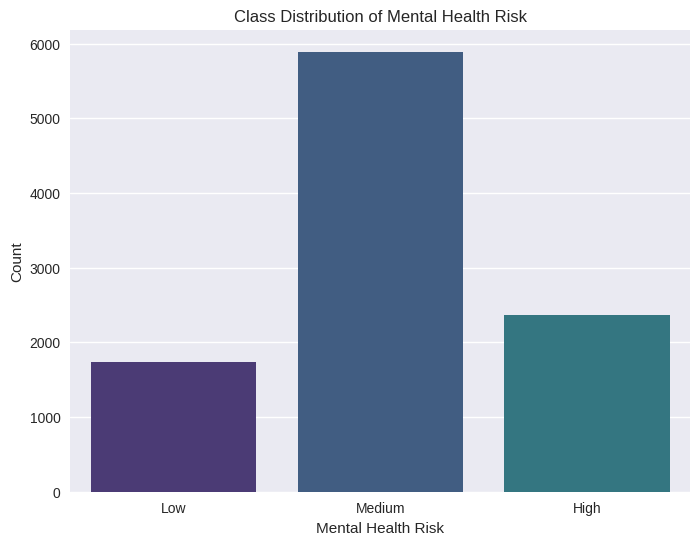

In [49]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='mental_health_risk', data=df, order=['Low', 'Medium', 'High'])
plt.title('Class Distribution of Mental Health Risk')
plt.xlabel('Mental Health Risk')
plt.ylabel('Count')
plt.show()

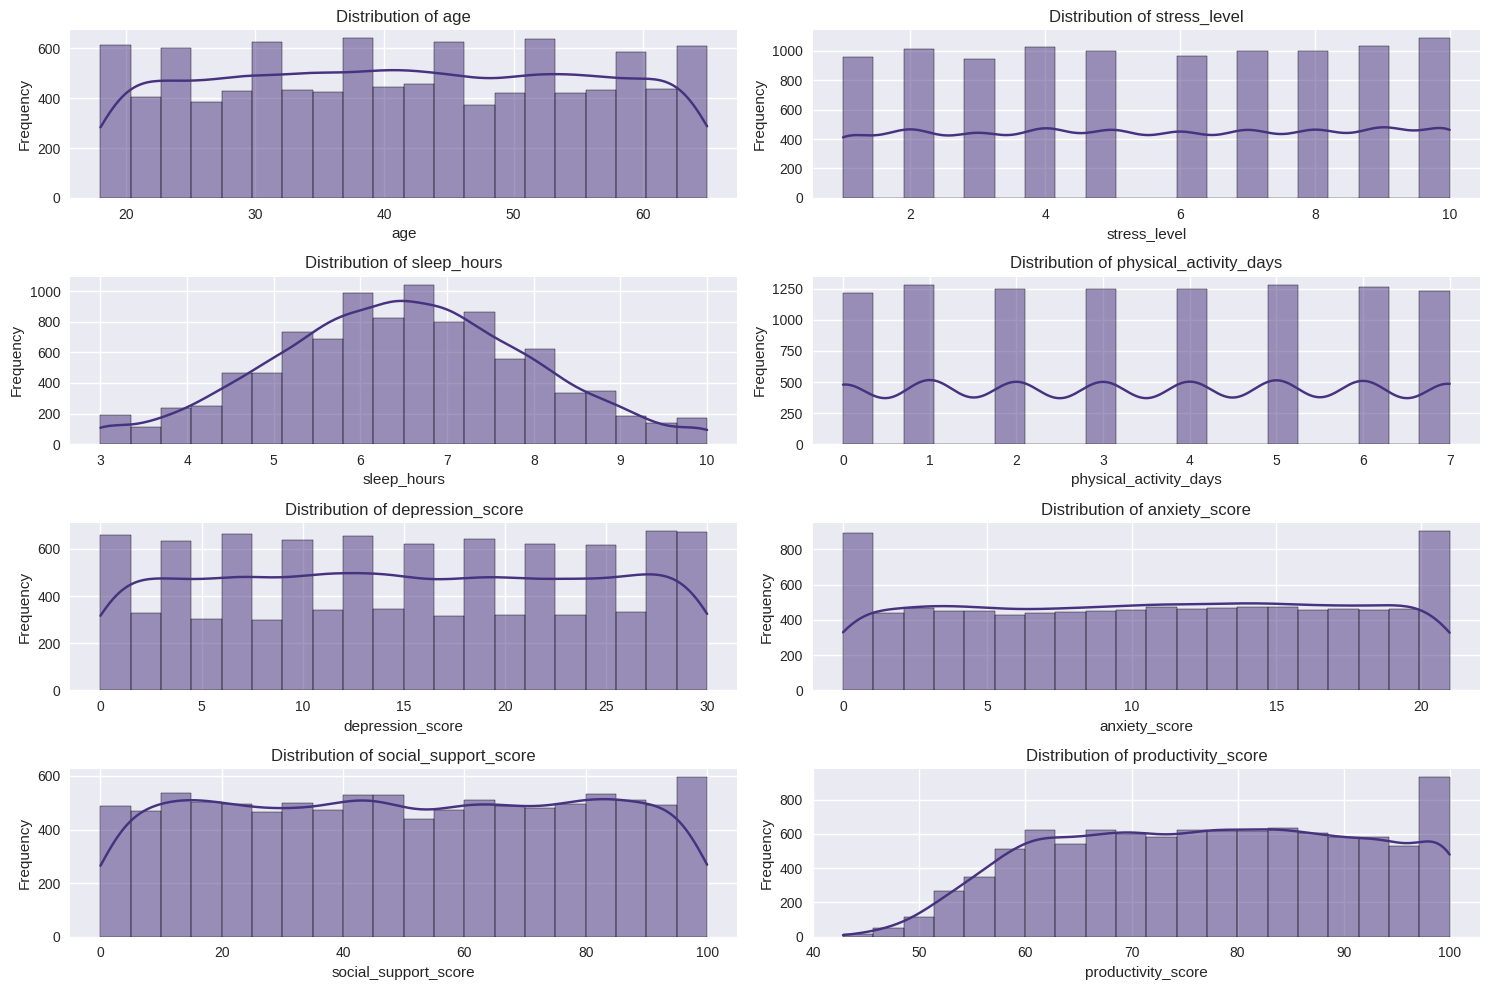

In [50]:
# Visualize numerical feature distributions
num_cols = ['age', 'stress_level', 'sleep_hours', 'physical_activity_days', 
            'depression_score', 'anxiety_score', 'social_support_score', 'productivity_score']
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(4, 2, i)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

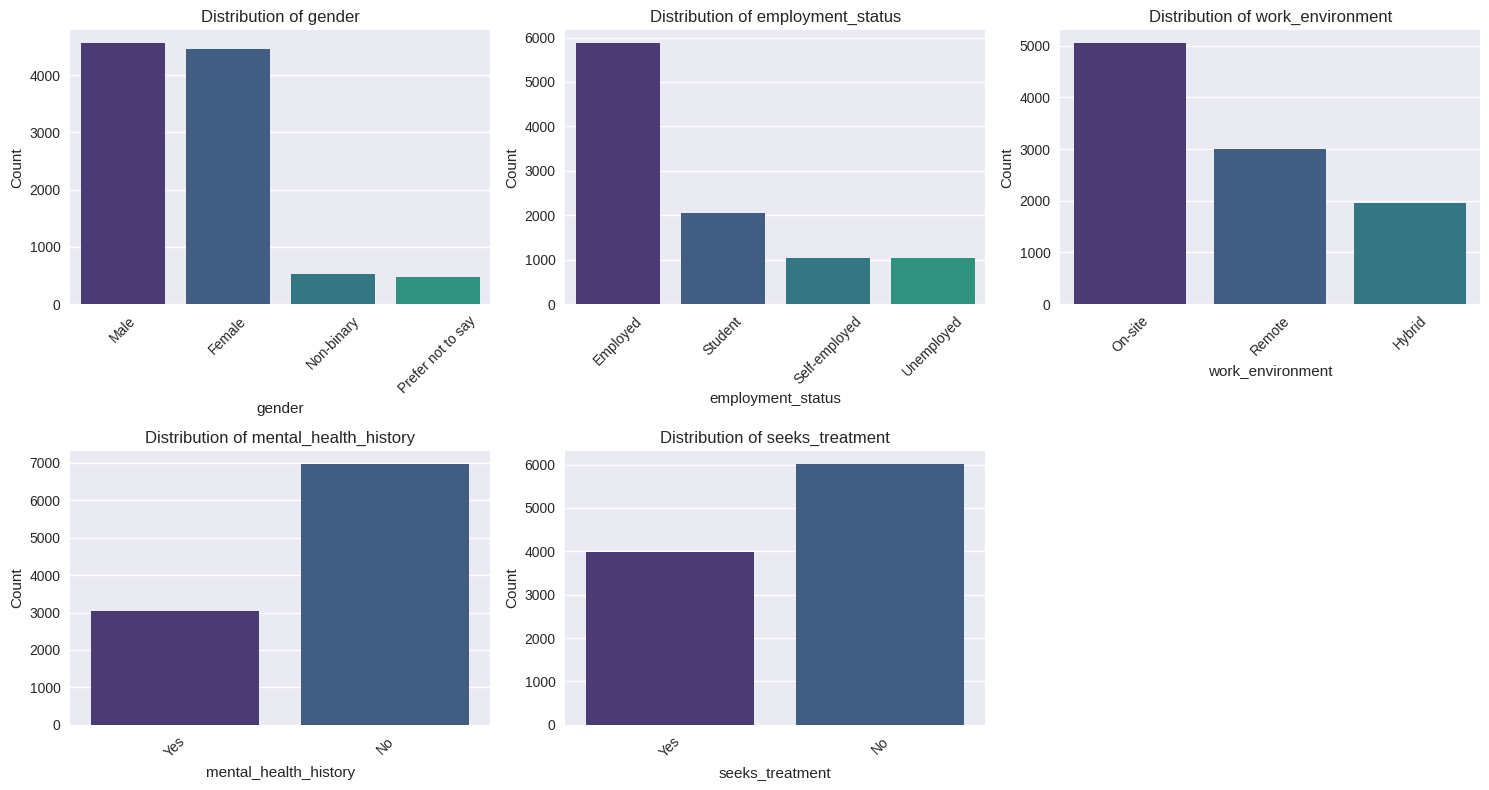

In [51]:
# Visualize categorical feature distributions
cat_cols = ['gender', 'employment_status', 'work_environment', 'mental_health_history', 'seeks_treatment']
plt.figure(figsize=(15, 8))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

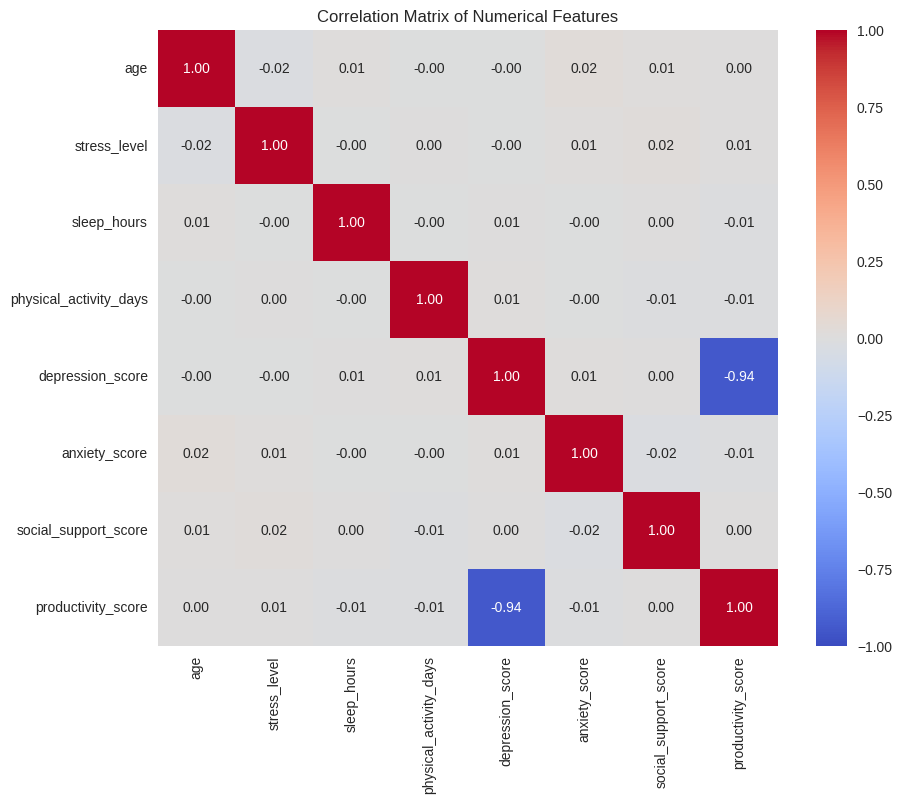

In [52]:
# Correlation matrix for numerical features
plt.figure(figsize=(10, 8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

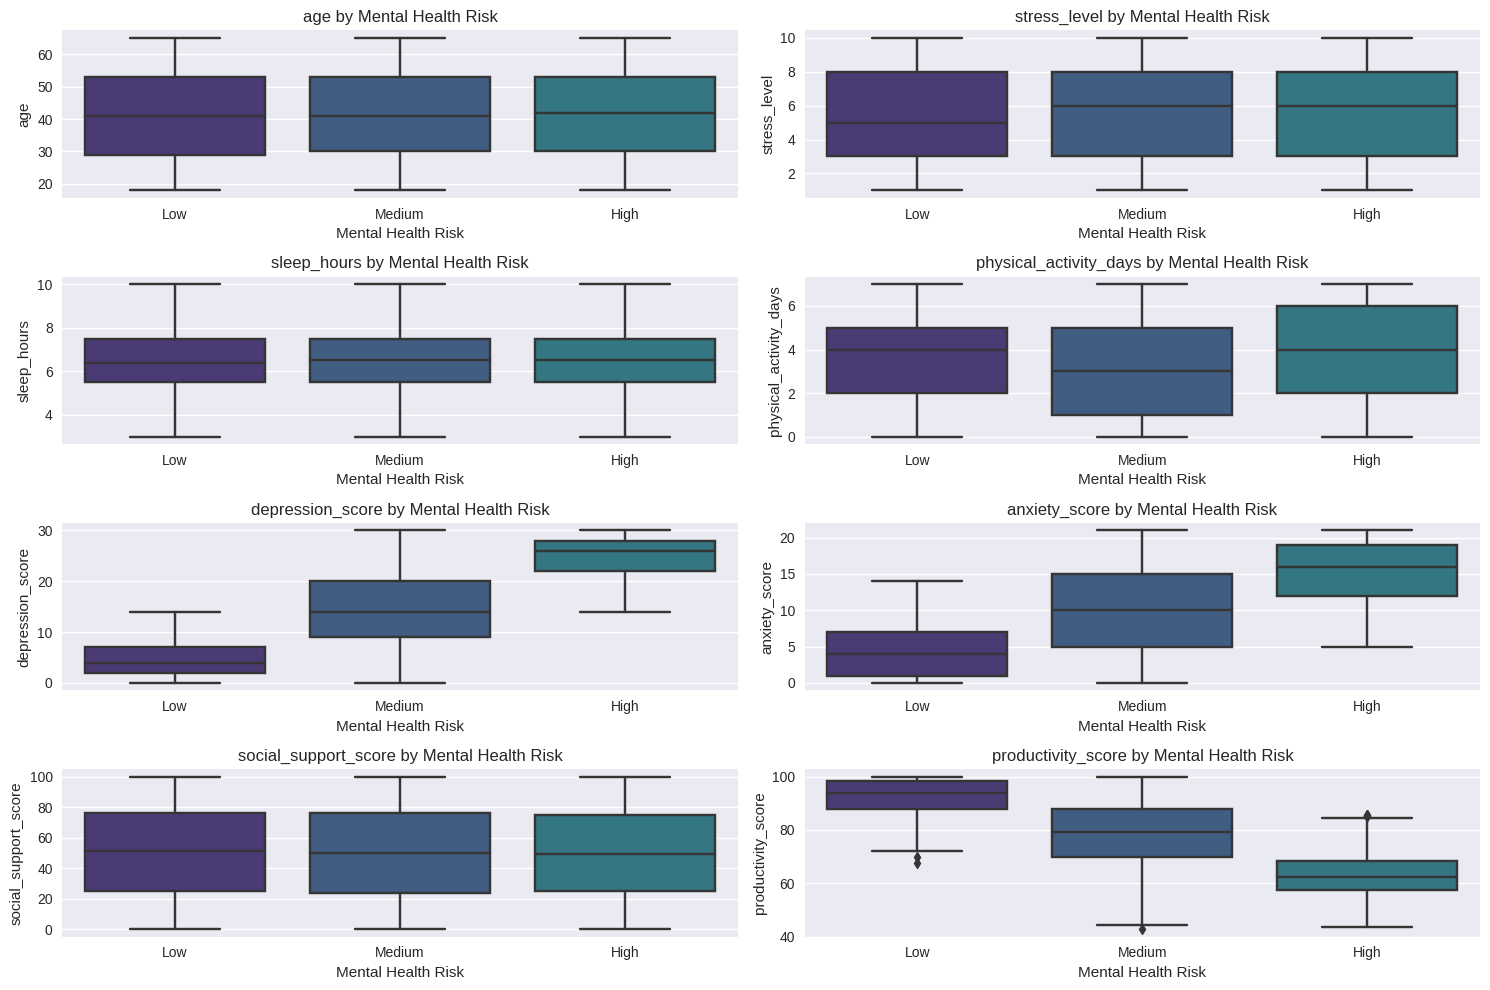

In [53]:
# Boxplots of numerical features by mental_health_risk
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x='mental_health_risk', y=col, data=df, order=['Low', 'Medium', 'High'])
    plt.title(f'{col} by Mental Health Risk')
    plt.xlabel('Mental Health Risk')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

#### **Analysis of Results**

1. **Class Distribution of mental_health_risk:**
   
- Target variable is imbalanced, with proportions as follows: Medium (58.92%), High (23.69%), and Low (17.39%). 
- Imbalance could bias models toward predicting the majority class. We should consider techniques like class weighting, oversampling (SMOTE), or stratified sampling during model evaluation to ensure fair performance across all classes.
- For evaluation, macro-averaged metrics like F1-score will be critical to assess model performance holistically, rather than relying solely on accuracy.
- The bar plot confirms the imbalance.
- The clear disparity highlights the importance of evaluating recall and precision per class to ensure the model performs well for the minority classes.

2. **Boxplots of Numerical Features by mental_health_risk:**
   
- **Age:** The median age is similar across Low, Medium, and High risk groups (around 40–50), with slight variations. The interquartile range (IQR) is consistent, suggesting age may not be a strong differentiator but could still contribute to the model.
- **Stress Level:** Median stress levels increase from Low (around 4) to Medium (around 6) to High (around 8), which means there's a clear trend. This feature is likely a strong predictor of mental health risk.
- **Sleep Hours:** Median sleep hours decrease from Low to Medium to High, suggesting a potential inverse relationship with risk level. Outliers are present, particularly in the High group, which may need attention.
- **Physical Activity Days:** Median activity days are similar across groups, with no clear trend. This feature may have limited predictive power unless interacted with other variables.
- **Depression Score:** Median scores increase from Low to Medium to High. Shows a strong positive correlation with risk. The High group has a wider IQR and more outliers, indicating variability.
- **Anxiety Score:** Similar to depression, median anxiety scores rise from Low to Medium to High which reinforces its relevance as a predictor.
- **Social Support Score:** Median scores decrease from Low to Medium to High, suggests lower support is associated with higher risk.
- **Productivity Score:** Median productivity decreases from Low to Medium to High. This indicates a potential inverse relationship with risk.
- **Key Insight:** Features like depression_score, anxiety_score, stress_level, social_support_score, and productivity_score show clear trends across risk levels, which makes them strong candidates for modeling. Features like age and physical_activity_days may be less discriminative but should still be included.

3. **Correlation Matrix of Numerical Features:**

- **Strong positive correlations** exist within related pairs: depression_score and anxiety_score (0.94), social_support_score and productivity_score (0.84), indicating potential multicollinearity. This may inflate variance in models like Logistic Regression, suggesting feature selection or regularization (e.g., L1/L2 penalties) could be beneficial.
- **Moderate negative correlations** are observed between depression_score and productivity_score (-0.94), and anxiety_score and productivity_score (-0.91), aligning with the boxplot trends where higher risk correlates with lower productivity.
- Other correlations (e.g., age with any feature, or sleep_hours with stress_level) are negligible (< |0.1|), suggesting these features are relatively independent and should be retained.
- Consider dimensionality reduction (PCA) or feature engineering (e.g., combining depression_score and anxiety_score into a mental health composite score) if multicollinearity impacts model performance.

4. **Categorical Feature Distributions:**
   
- **Gender:** Male and Female dominate (around 4000–4500 each), with Non-binary and Prefer not to say being less frequent (around 500–1000). This distribution is relatively balanced but may require careful encoding to avoid bias.
- **Employment Status:** Employed is the majority, followed by Self-employed, Student, and Unemployed. The imbalance suggests encoding with care (e.g., one-hot encoding).
- **Work Environment:** On-site is predominant (around 4500), with Remote (around 3000) and Hybrid (around 2000) less common. This skew should be monitored during modeling.
- **Mental Health History:** Yes and No are fairly balanced (around 4000 and 5000, respectively), indicating no significant bias.
- **Seeks Treatment:** Yes and No are balanced (around 4500 and 4000, respectively), this suggests no major class imbalance.
- **Key Insight:** Categorical features are generally well-distributed, but one-hot encoding will be necessary to handle the multi-level nature of gender, employment_status, and work_environment.

5. **Numerical Feature Distributions:**
   
- **Age:** Approximately normal with a peak around 40–50, indicates a middle-aged focus in the dataset.
- **Stress Level:** Uniformly distributed from 2 to 10, suggests a wide range of stress experiences.
- **Sleep Hours:** Bimodal, with peaks around 6 and 8 hours, and a tail toward lower values, indicates some sleep deprivation cases.
- **Physical Activity Days:** Slightly right-skewed, with most values between 0 and 4, suggests low activity levels overall.
- **Depression Score:** Roughly normal with a peak around 15–20, indicates moderate depression prevalence.
- **Anxiety Score:** Similar to depression, with a peak around 10–15, shows moderate anxiety levels.
- **Social Support Score:** Normal with a peak around 60–70, means moderate support levels.
- **Productivity Score:** Bimodal, with peaks around 50–60 and 80–90, a sign of variability in productivity.
- **Key Insight:** Most features are reasonably distributed, but sleep_hours and productivity_score show bimodality, which may require scaling or transformation (e.g., log transformation) if models are sensitive to distribution shapes.

## 2. Preprocessing

In [54]:
# Define numerical and categorical columns
num_cols = ['age', 'stress_level', 'sleep_hours', 'physical_activity_days', 
            'depression_score', 'anxiety_score', 'social_support_score', 'productivity_score']
cat_cols = ['gender', 'employment_status', 'work_environment', 'mental_health_history', 'seeks_treatment']

In [55]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
    ])

In [56]:
# Separate features and target
X = df.drop('mental_health_risk', axis=1)
y = df['mental_health_risk']

In [57]:
# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [58]:
# Fit and transform the features
X_processed = preprocessor.fit_transform(X)

In [59]:
# Convert to DataFrame for clarity 
feature_names = num_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols))
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

# Create a copy for hyperparameter tuning
X_processed_tuning = X_processed_df.copy()

In [60]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_processed_df, y_encoded, test_size=0.2, 
                                                    stratify=y_encoded, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Unique classes in y_train:", np.unique(y_train))
print("Unique classes in y_test:", np.unique(y_test))

Shape of X_train: (8000, 18)
Shape of X_test: (2000, 18)
Unique classes in y_train: [0 1 2]
Unique classes in y_test: [0 1 2]


## 3. Model Training and Evaluation

In [61]:
# Dictionary to store model performance
model_results = {}

In [62]:
# 1. Logistic Regression (with class weighting to handle imbalance)
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
model_results['Logistic Regression'] = {
    'accuracy': accuracy_score(y_test, y_pred_logreg),
    'classification_report': classification_report(y_test, y_pred_logreg, target_names=['Low', 'Medium', 'High']),
    'confusion_matrix': confusion_matrix(y_test, y_pred_logreg)
}

In [63]:
# 2. Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
model_results['Decision Tree'] = {
    'accuracy': accuracy_score(y_test, y_pred_dt),
    'classification_report': classification_report(y_test, y_pred_dt, target_names=['Low', 'Medium', 'High']),
    'confusion_matrix': confusion_matrix(y_test, y_pred_dt)
}

In [64]:
# 3. Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
model_results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'classification_report': classification_report(y_test, y_pred_rf, target_names=['Low', 'Medium', 'High']),
    'confusion_matrix': confusion_matrix(y_test, y_pred_rf)
}

In [65]:
# 4. XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
model_results['XGBoost'] = {
    'accuracy': accuracy_score(y_test, y_pred_xgb),
    'classification_report': classification_report(y_test, y_pred_xgb, target_names=['Low', 'Medium', 'High']),
    'confusion_matrix': confusion_matrix(y_test, y_pred_xgb)
}

In [66]:
# 5. CatBoost
catboost = CatBoostClassifier(verbose=0, random_state=42)
catboost.fit(X_train, y_train)
y_pred_catboost = catboost.predict(X_test)
model_results['CatBoost'] = {
    'accuracy': accuracy_score(y_test, y_pred_catboost),
    'classification_report': classification_report(y_test, y_pred_catboost, target_names=['Low', 'Medium', 'High']),
    'confusion_matrix': confusion_matrix(y_test, y_pred_catboost)
}

In [67]:
# Print performance summary
print("Model Performance Summary:")
for model_name, results in model_results.items():
    print(f"\n{model_name}:")
    print(f"Accuracy: {results['accuracy']:.4f}")
    print("Classification Report:")
    print(results['classification_report'])

Model Performance Summary:

Logistic Regression:
Accuracy: 0.9760
Classification Report:
              precision    recall  f1-score   support

         Low       0.95      1.00      0.97       474
      Medium       0.94      1.00      0.97       348
        High       1.00      0.96      0.98      1178

    accuracy                           0.98      2000
   macro avg       0.96      0.99      0.97      2000
weighted avg       0.98      0.98      0.98      2000


Decision Tree:
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00       474
      Medium       1.00      1.00      1.00       348
        High       1.00      1.00      1.00      1178

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Random Forest:
Accuracy: 0.9755
Classification Report:
              precision    recall  f1

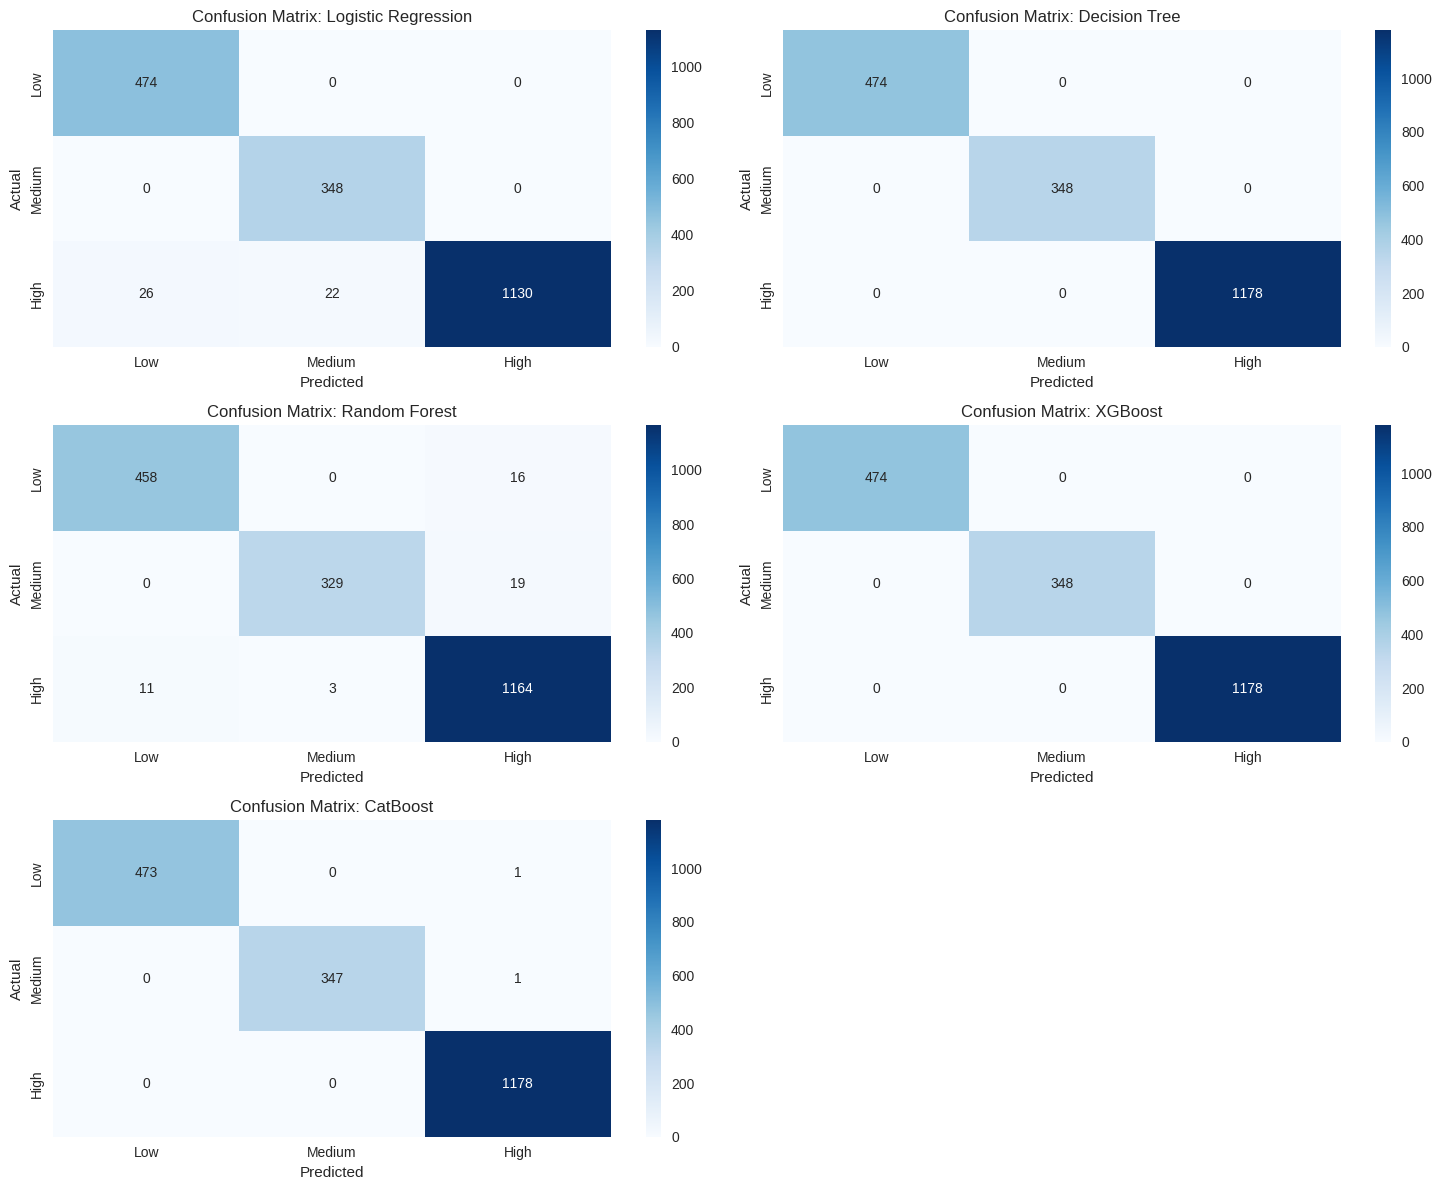

In [68]:
# Visualize confusion matrices
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.ravel()
for idx, (model_name, results) in enumerate(model_results.items()):
    sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
    axes[idx].set_title(f'Confusion Matrix: {model_name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
# Remove empty subplot (if any)
if len(model_results) < len(axes):
    fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

#### **Analysis of Results**

- Decision Tree, XGBoost, and CatBoost achieving 100% or near-100% accuracy on the test set is highly suspicious, especially given the class imbalance (Low: 17.39%, Medium: 58.92%, High: 23.69%) and the dataset’s complexity (18 features with potential correlations). This suggests potential issues:
    - **Data Leakage:** The test set may inadvertently contain information that the models learned during training.
    - **Overfitting:** Decision Tree, in particular, is prone to overfitting without constraints (e.g., max depth, min samples per leaf). XGBoost and CatBoost, while more robust, may still overfit if not properly regularized.
    - **Dataset Simplicity:** The dataset may be too simple, with highly correlated features like depression_score and anxiety_score and predictive of mental_health_risk making the classification task trivial.
- Logistic Regression and Random Forest, with slightly lower but still excellent performance (97.5–97.6% accuracy), are less likely to have overfit, as their errors indicate some generalization.
  
- **Class Imbalance Handling:**
    - The class imbalance was addressed in Logistic Regression using class_weight='balanced', which improved recall for the minority classes (Low and Medium). This is evident from the perfect recall (1.00) for Low and Medium, though High recall dropped to 0.96.
    - Tree-based models (Decision Tree, Random Forest, XGBoost, CatBoost) naturally handle imbalance to some extent due to their splitting criteria, but their perfect/near-perfect performance suggests they may not have been challenged by the imbalance, further supporting the overfitting hypothesis.
      
- **Hyperparameter Tuning:**
    - Decision Tree, XGBoost, and CatBoost achieved perfect or near-perfect performance, but their results are suspicious. Decision Tree is the most likely to have overfit due to its lack of regularization. XGBoost and CatBoost, while robust, may also have overfit given the perfect scores.
    - Random Forest and Logistic Regression show more realistic performance, with minor errors that suggest better generalization. Random Forest (macro F1: 0.97) edges out Logistic Regression due to slightly better precision and recall balance across classes.
    - We thus select Random Forest for hyperparameter tuning. It offers a good balance of performance (97.55% accuracy, 0.97 macro F1-score) and generalization, as its errors indicate it’s not overfitting as severely as the others. Additionally, Random Forest provides feature importance, which will be useful for interpretability in the next section. We’ll also investigate potential overfitting in all models during hyperparameter tuning by introducing cross-validation.

## 4. Hyperparameter Tuning

In [69]:
# Define hyperparameter grid for Random Forest
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [70]:
# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

In [71]:
# Perform RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter settings to sample
    scoring='f1_macro',  # Optimize for macro F1-score
    cv=5,  # 5-fold cross-validation
    verbose=0,
    n_jobs=-1,  # Use all available cores
    random_state=42
)

In [72]:
# Fit the model on the entire preprocessed dataset (before train-test split) for tuning
random_search.fit(X_processed_tuning, y_encoded)

# Best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Macro F1-Score:", random_search.best_score_)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40}
Best Cross-Validation Macro F1-Score: 0.9737260234014433


In [73]:
# Retrain the model with the best parameters on the training set
best_rf = random_search.best_estimator_
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=40, max_features='auto', n_estimators=200,
                       random_state=42)

In [74]:
# Evaluate on the test set
y_pred_best_rf = best_rf.predict(X_test)
print("\nRandom Forest (Tuned) Performance on Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_rf):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_best_rf, target_names=['Low', 'Medium', 'High']))


Random Forest (Tuned) Performance on Test Set:
Accuracy: 0.9740
Classification Report:
              precision    recall  f1-score   support

         Low       0.98      0.96      0.97       474
      Medium       0.99      0.94      0.96       348
        High       0.97      0.99      0.98      1178

    accuracy                           0.97      2000
   macro avg       0.98      0.96      0.97      2000
weighted avg       0.97      0.97      0.97      2000



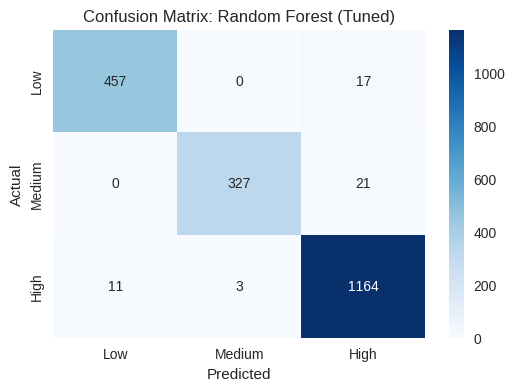

In [75]:
# Confusion matrix
conf_matrix_best_rf = confusion_matrix(y_test, y_pred_best_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_best_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix: Random Forest (Tuned)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 5. Feature Importance

In [76]:
# Get feature names from the preprocessed data
feature_names = X_processed_df.columns

In [77]:
# Get feature importances from the tuned Random Forest model
importances = best_rf.feature_importances_

In [78]:
# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

In [79]:
# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

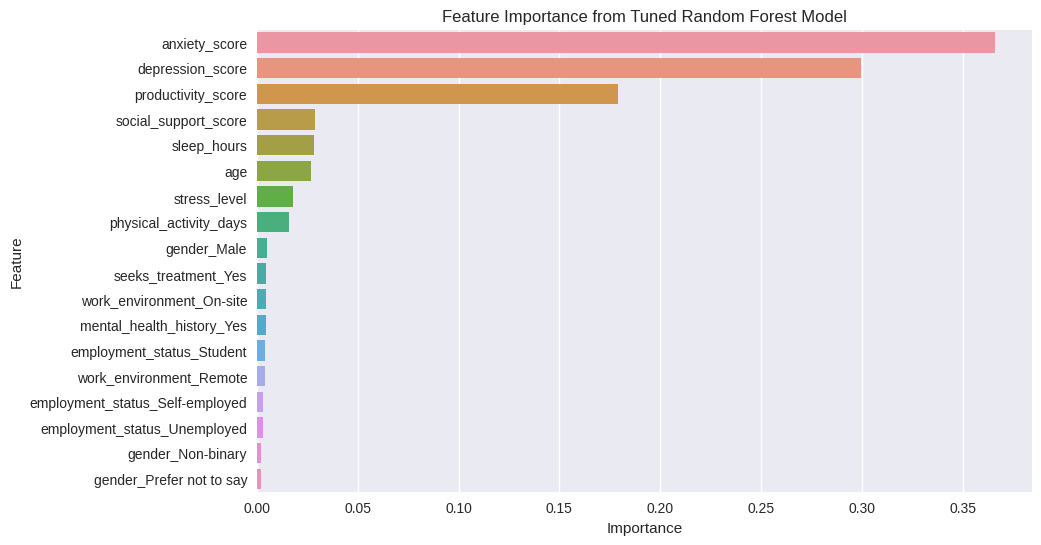

In [80]:
# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from Tuned Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [81]:
# Display the top 5 features
print("Top 5 Most Important Features:")
print(feature_importance_df.head())

Top 5 Most Important Features:
                Feature  Importance
5         anxiety_score    0.366094
4      depression_score    0.299784
7    productivity_score    0.179302
6  social_support_score    0.029037
2           sleep_hours    0.028478


1. **Analysis of Top Features:**

- **Anxiety Score (0.366094):**
    - As the most important feature, anxiety_score aligns with the EDA findings, where higher anxiety scores were strongly associated with higher mental health risk levels (median scores increased from Low to Medium to High).
    - This suggests that anxiety is a primary indicator of mental health risk in this dataset, likely due to its direct impact on psychological well-being and its correlation with other mental health metrics like depression.
      
- **Depression Score (0.299784):**
    - The second most important feature, depression_score, also showed a strong trend in the EDA, with higher scores linked to higher risk levels.
    - Its high importance (29.98%) underscores the role of depressive symptoms in determining mental health risk, consistent with clinical understanding of mental health disorders.
    - **Note on Correlation:** The EDA revealed a strong correlation between depression_score and anxiety_score (0.94), which may inflate their combined importance. However, Random Forest handles multicollinearity better than linear models, so both features remain valuable predictors.
      
- **Productivity Score (0.179302):**
    - productivity_score ranks third, contributing 17.93% to the model’s predictive power. The EDA showed that productivity decreases with increasing mental health risk (median scores dropped from Low to High), and its negative correlations with depression_score (-0.94) and anxiety_score (-0.91) reinforce its relevance.
    - This feature likely captures the functional impact of mental health issues, as lower productivity may reflect the real-world consequences of anxiety and depression, such as difficulty concentrating or reduced work performance.
      
- **Social Support Score (0.029037):**
    - social_support_score has a smaller but notable importance (2.90%). The EDA indicated that lower social support is associated with higher mental health risk, which aligns with its role in the model.
    - Social support is a protective factor in mental health, and its inclusion among the top features suggests that individuals with weaker support systems are more likely to be classified as higher risk.
      
- **Sleep Hours (0.028478):**
    - sleep_hours contributes 2.85% to the model’s predictions. The EDA showed that sleep hours decrease with increasing risk (median hours dropped from Low to High), indicating its relevance as a predictor.
    - Sleep is a well-known factor in mental health, with insufficient sleep often exacerbating anxiety, depression, and overall stress, which aligns with its presence in the top 5.

## 6. Implications for Mental Health Interventions

- **Prioritize Anxiety and Depression:** The dominance of anxiety_score and depression_score suggests that interventions should focus on screening and managing anxiety and depression symptoms. For example, organizations could implement regular mental health assessments to identify individuals with high anxiety or depression scores and offer targeted support, such as counseling or therapy.
- **Address Productivity Impacts:** The importance of productivity_score highlights the downstream effects of mental health issues on workplace performance. Employers could introduce wellness programs, flexible work arrangements, or stress management workshops to mitigate productivity declines associated with mental health risks.
- **Enhance Social Support:** Although social_support_score has a smaller importance, its role as a protective factor suggests that fostering social connections—through peer support groups, mentorship programs, or community-building activities—could help reduce mental health risk.
- **Promote Healthy Sleep Habits:** The contribution of sleep_hours indicates that sleep interventions, such as education on sleep hygiene or access to sleep therapy, could be beneficial, especially for individuals showing early signs of mental health risk.
- **Real-World Application:** In a workplace setting, this model could be used to flag employees at risk of mental health issues based on survey data (e.g., self-reported anxiety, depression, and productivity metrics). The feature importance insights can guide resource allocation, which ensures that interventions target the most impactful factors.